# 09. PyTorch Model Deployment

## 00. Getting setup

In [7]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [8]:
device = "mps" if torch.mps.is_available() else "cpu"

## 01. Getting data

In [9]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [10]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 02. Foodvision mini model deployment experiment outline

Our goals are:
1. **Performance** - A model that performs at 95% + accuracy
2. **Speed** - A model that can classify an image at ~ 30FPS

## 03. Creating an EffNetB2 feature extractor

1. Setup the pretrained weights as `weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT`,

   where `DEFAULT` means best currently available

2. Get the pretrained model image transforms from the weights with the `transforms()` method.

3. Create a pretrained model instance by passing the weights to an instance of `torchvision.models.efficientnet_b2`.

4. Freeeze the base layers in the model.

5. Update the classifier head to suit our own data

In [11]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)
for param in effnetb2.features.parameters():
    param.requires_grad = False

effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [12]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=3)
)

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [13]:
def create_effnetb2_model(num_classes: int=3,
                          seed: int=37):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)
    for param in model.features.parameters():
        param.requires_grad = False
    torch.manual_seed(seed=seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408,
                out_features=num_classes)
    )

    return model, transforms

In [16]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,seed=37)
effnetb2 = effnetb2.to(device=device)
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

### 3.2 Creating dataloaders for EffnetB2

In [17]:
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=effnetb2_transforms,
                                                                               batch_size=32,
                                                                               num_workers=0)

### 3.3 Training EffNetB2 feature extractor

In [18]:
from going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

set_seeds(37)

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device,
                                writer=None)

 10%|█         | 1/10 [00:04<00:41,  4.56s/it]

Epoch: 1 | train_loss: 1.0036 | train_acc: 0.5437 | test_loss: 0.7325 | test_acc: 0.9131


 20%|██        | 2/10 [00:07<00:30,  3.83s/it]

Epoch: 2 | train_loss: 0.7441 | train_acc: 0.7833 | test_loss: 0.5950 | test_acc: 0.9477


 30%|███       | 3/10 [00:11<00:25,  3.62s/it]

Epoch: 3 | train_loss: 0.6267 | train_acc: 0.8271 | test_loss: 0.5104 | test_acc: 0.9477


 40%|████      | 4/10 [00:14<00:21,  3.52s/it]

Epoch: 4 | train_loss: 0.5264 | train_acc: 0.8646 | test_loss: 0.4487 | test_acc: 0.9443


 50%|█████     | 5/10 [00:17<00:17,  3.47s/it]

Epoch: 5 | train_loss: 0.5038 | train_acc: 0.8375 | test_loss: 0.4277 | test_acc: 0.9352


 60%|██████    | 6/10 [00:21<00:13,  3.47s/it]

Epoch: 6 | train_loss: 0.4530 | train_acc: 0.8708 | test_loss: 0.3762 | test_acc: 0.9381


 70%|███████   | 7/10 [00:25<00:10,  3.55s/it]

Epoch: 7 | train_loss: 0.4057 | train_acc: 0.9062 | test_loss: 0.3713 | test_acc: 0.9352


 80%|████████  | 8/10 [00:28<00:07,  3.62s/it]

Epoch: 8 | train_loss: 0.3975 | train_acc: 0.8958 | test_loss: 0.3292 | test_acc: 0.9381


 90%|█████████ | 9/10 [00:32<00:03,  3.68s/it]

Epoch: 9 | train_loss: 0.3464 | train_acc: 0.9042 | test_loss: 0.2987 | test_acc: 0.9568


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]

Epoch: 10 | train_loss: 0.3756 | train_acc: 0.8896 | test_loss: 0.2896 | test_acc: 0.9506


### 3.4 Inspecting EffnetB2 loss curves

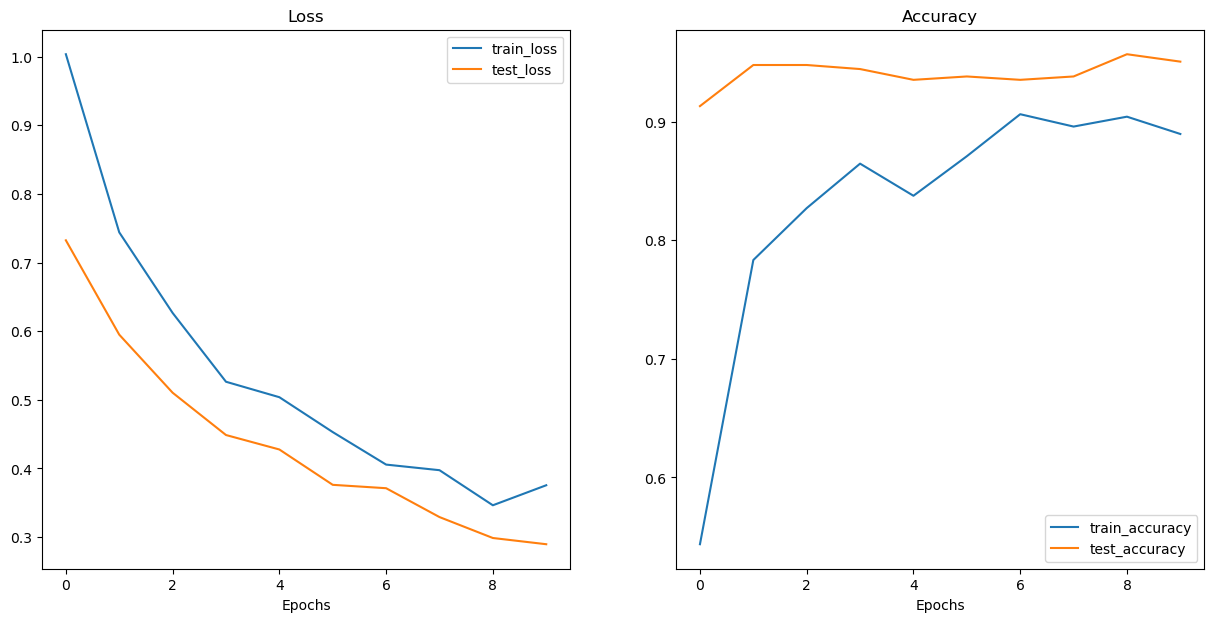

In [19]:
from helper_functions import plot_loss_curves
plot_loss_curves(results=effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [20]:
from going_modular import utils

# Save the model
utils.save_model(model=effnetb2, target_dir="models", model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


## 3.6 Checking the size of EffNetB2 feature extractor

In [21]:
from pathlib import Path

# get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path(
    "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"
).stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")


Pretrained EffNetB2 feature extractor model size: 29 MB


## 3.7 Collecting EffNetB2 feature extractor stats

In [22]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [23]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.289645180106163,
 'test_acc': 0.9505681818181818,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 4. Creating a ViT feature extractor

In [24]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [25]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

In [26]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)
vit = vit.to(device)

In [27]:
# Setup ViT DataLoaders
from going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [28]:
from going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,
                           writer=None)

 10%|█         | 1/10 [00:04<00:44,  4.95s/it]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290


 20%|██        | 2/10 [00:09<00:38,  4.86s/it]

Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602


 30%|███       | 3/10 [00:14<00:34,  4.87s/it]

Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693


 40%|████      | 4/10 [00:19<00:28,  4.83s/it]

Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722


 50%|█████     | 5/10 [00:24<00:23,  4.78s/it]

Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784


 60%|██████    | 6/10 [00:28<00:19,  4.76s/it]

Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722


 70%|███████   | 7/10 [00:33<00:14,  4.81s/it]

Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784


 80%|████████  | 8/10 [00:38<00:09,  4.83s/it]

Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722


 90%|█████████ | 9/10 [00:43<00:04,  4.78s/it]

Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784


100%|██████████| 10/10 [00:47<00:00,  4.80s/it]

Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


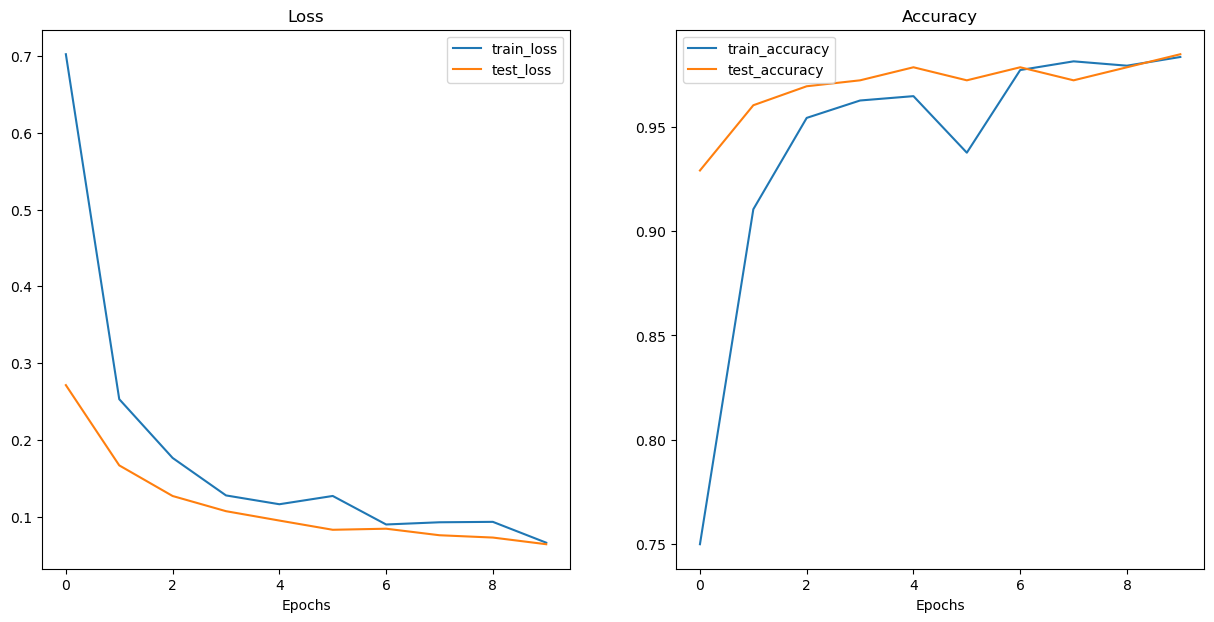

In [30]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [31]:
# Save the model
from going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [32]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")


Pretrained ViT feature extractor model size: 327 MB


In [33]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [34]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06418207408860326,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 5. Making predictions with our trained models and timing them

In [35]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1982192.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg')]

### 5.1 Creating a function to make predictions across the test dataset

In [36]:
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "mps" if torch.mps.is_available() else "cpu") -> List[Dict]:
    # 2. Create an empty list to store prediction dictionaries
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. start the predcition timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, prediction label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            # 11. Make sure things in the dictionary are on cpu
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(),4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time,4)


        # 13. Does the pred match the true label
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. return list of prediction dictionaries
    return pred_list

## 5.2 making and timing predictions with effnetb2

In [37]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU 
                                          

100%|██████████| 150/150 [01:05<00:00,  2.30it/s]


In [38]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9132,
  'pred_class': 'steak',
  'time_for_pred': 0.6043,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9253,
  'pred_class': 'steak',
  'time_for_pred': 0.4332,
  'correct': True}]

In [39]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.9132,steak,0.6043,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9253,steak,0.4332,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.8890,steak,0.4394,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.7329,steak,0.4360,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.6141,steak,0.4332,True


In [40]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     143
False      7
Name: count, dtype: int64

In [41]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.4348 seconds


In [42]:
# Add EffNetB2 average prediction time to stats dictionary 
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.289645180106163,
 'test_acc': 0.9505681818181818,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': np.float64(0.4348)}

## 5.3 Making and timing predictions with Vit

In [43]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

100%|██████████| 150/150 [00:09<00:00, 16.30it/s]


In [44]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7901,
  'pred_class': 'steak',
  'time_for_pred': 0.2537,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9981,
  'pred_class': 'steak',
  'time_for_pred': 0.062,
  'correct': True}]

In [45]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.7901,steak,0.2537,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9981,steak,0.0620,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9959,steak,0.0588,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9858,steak,0.0629,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9516,steak,0.0602,True


In [46]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [47]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.0611 seconds


In [48]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06418207408860326,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': np.float64(0.0611)}

## 6. Comparing model results, prediction times and size


In [49]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.289645,95.06,7705221,29,0.4348,EffNetB2
1,0.064182,98.47,85800963,327,0.0611,ViT


In [50]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.221589,1.035872,11.135432,11.275862,0.140524


## 6.1 Visualizing the speed vs. performance tradeoff

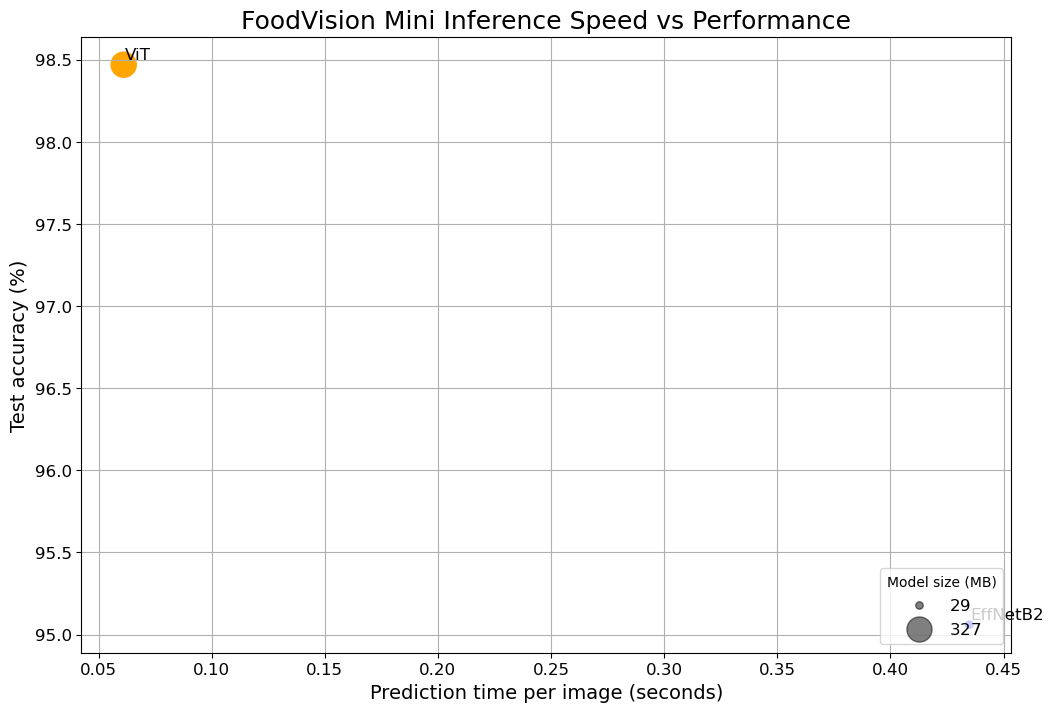

In [51]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

## 7. Bringing FoodVision Mini to life by createing a Gradio demo

In [52]:
import gradio as gr

### 7.1 Gradio overview

### 7.2 Creating a function to map our inputs and outputs

In [53]:
# Put EffnetB2 on Cpu
effnetb2.to("cpu")

# check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [54]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

In [55]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/697562.jpg

Prediction label and probability dictionary: 
{'pizza': 0.15185201168060303, 'steak': 0.6771581172943115, 'sushi': 0.17098988592624664}
Prediction time: 0.4358 seconds


### 7.3 creating a list of example images

Our `predict()` function enables us to go from inputs -> transform -> ML model -> outputs.

Which is exactly what we need for our Graido demo.

But before we create the demo, let's create one more thing: a list of examples.

Gradio's Interface class takes a list of examples of as an optional parameter (gradio.Interface(examples=List[Any])).

And the format for the examples parameter is a list of lists.

So let's create a list of lists containing random filepaths to our test images.

Three examples should be enough.

In [57]:
# Create a list of example inputs to our gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)] 
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/911808.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/746921.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg']]

### 7.4 Building a Gradio interface

In [58]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://46ae420ade3ccb1d41.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Gradio Demo into a deployable app

### 8.1 What is hugging face spaces

### 8.2 Deployed Gradio app structure

### 8.3 Creating a demos folder to store our FoodVision Mini app files

In [59]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
# If the file doesn't exist, create it anyway
foodvision_mini_demo_path.mkdir(parents=True, 
                                exist_ok=True)
    


## 8.4 Creating a folder of example images to use with our FoodVision Mini demo

In [60]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [61]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list


[['examples/2582289.jpg'], ['examples/592799.jpg'], ['examples/3622237.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [62]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model 
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
    
    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path, 
                dst=effnetb2_foodvision_mini_model_destination)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### 8.6 Turning our EffNetB2 model into a Python script (model.py)

In [63]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/foodvision_mini/model.py


### 8.7 Turning our FoodVision Mini Gradio app into a Python script (app.py)

In [64]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


In [65]:
import gradio


print(torch.__version__)
print(torchvision.__version__)
print(gradio.__version__)

2.7.0
0.22.0
5.35.0


### 8.8 Creating a requirements file for FoodVision Mini (requirements.txt)

In [66]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.7.0
torchvision==0.22.0
gradio==5.35.0

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app to HuggingFace Spaces

### 9.1 Downloading our FoodVision Mini app files

In [67]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"


  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 57%)
  adding: examples/ (stored 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 6%)


### 9.3 Uploading to Hugging Face

We've verified our FoodVision Mini app works locally, however, the fun of creating a machine learning demo is to show it to other people and allow them to use it.

To do so, we're going to upload our FoodVision Mini demo to Hugging Face.

Note: The following series of steps uses a Git (a file tracking system) workflow. For more on how Git works, I'd recommend going through the Git and GitHub for Beginners tutorial on freeCodeCamp.

* Sign up for a Hugging Face account.
* Start a new Hugging Face Space by going to your profile and then clicking "New Space".
Note: A Space in Hugging Face is also known as a "code repository" (a place to store your code/files) or "repo" for short.
* Give the Space a name, for example, mine is called mrdbourke/foodvision_mini, you can see it here: https://huggingface.co/spaces/mrdbourke/foodvision_mini
* Select a license (I used MIT).
* Select Gradio as the Space SDK (software development kit).
Note: You can use other options such as Streamlit but since our app is built with Gradio, we'll stick with that.
* Choose whether your Space is it's public or private (I selected public since I'd like my Space to be available to others).
* Click "Create Space".
* Clone the repo locally by running something like: git clone https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME] in terminal or command prompt.
Note: You can also add files via uploading them under the "Files and versions" tab.
* Copy/move the contents of the downloaded foodvision_mini folder to the cloned repo folder.
* To upload and track larger files (e.g. files over 10MB or in our case, our PyTorch model file) you'll need to install Git LFS (which stands for "git large file storage").
* After you've installed Git LFS, you can activate it by running git lfs install.
* In the foodvision_mini directory, track the files over 10MB with Git LFS with git lfs track "*.file_extension".
Track EffNetB2 PyTorch model file with git lfs track "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth".
* Track .gitattributes (automatically created when cloning from HuggingFace, this file will help ensure our larger files are tracked with Git LFS). You can see an example .gitattributes file on the FoodVision Mini Hugging Face Space.
git add .gitattributes
* Add the rest of the foodvision_mini app files and commit them with:
git add *
git commit -m "first commit"
vPush (upload) the files to Hugging Face:
git push
* Wait 3-5 minutes for the build to happen (future builds are faster) and your app to become live!

## 10. Creating FoodVision Big
### 10.1 Creating a model and transforms for FoodVision Big

In [68]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [70]:
effnetb2_food101.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=101, bias=True)
)

In [72]:
from torchinfo import summary

# # Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes (uncomment for full output)
# summary(effnetb2_food101, 
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [75]:
# Create Food101 training data transforms
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

In [77]:
print(f"Training transforms:\n{food101_train_transforms}\n") 
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


### 10.2 Getting data for FoodVision Big

In [78]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_train_transforms,
                              download=True)
# Get testing data
test_data = datasets.Food101(root=data_dir,
                              split="test",
                              transform=effnetb2_transforms,# perform normal EffNetB2 transforms on test data
                              download=True)

In [79]:
# Get Food101 class names
food101_class_name = train_data.classes

# view the first 10
food101_class_name[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of the Food101 dataset for faster experimenting

In [80]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split? 
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and 
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length
        
    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")
    
    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset, 
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [81]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

### 10.4 Turning our Food101 datasets into DataLoaders

In [88]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

### 10.5 Training FoodVision Big model

In [89]:
from going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()    
effnetb2_food101_results = engine.train(model=effnetb2_food101.to(device),
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device,
                                        writer=None)

 20%|██        | 1/5 [01:33<06:15, 93.76s/it]

Epoch: 1 | train_loss: 2.7305 | train_acc: 0.4868 | test_loss: 2.4743 | test_acc: 0.5309


 40%|████      | 2/5 [03:05<04:37, 92.49s/it]

Epoch: 2 | train_loss: 2.6740 | train_acc: 0.4730 | test_loss: 2.3658 | test_acc: 0.5549


 60%|██████    | 3/5 [04:36<03:03, 91.96s/it]

Epoch: 3 | train_loss: 2.5674 | train_acc: 0.5075 | test_loss: 2.2982 | test_acc: 0.5728


 80%|████████  | 4/5 [06:07<01:31, 91.50s/it]

Epoch: 4 | train_loss: 2.4906 | train_acc: 0.5209 | test_loss: 2.2774 | test_acc: 0.5793


100%|██████████| 5/5 [07:38<00:00, 91.74s/it]

Epoch: 5 | train_loss: 2.4594 | train_acc: 0.5328 | test_loss: 2.2618 | test_acc: 0.5814


### 10.6 Inspecting loss curves of FoodVision Big model

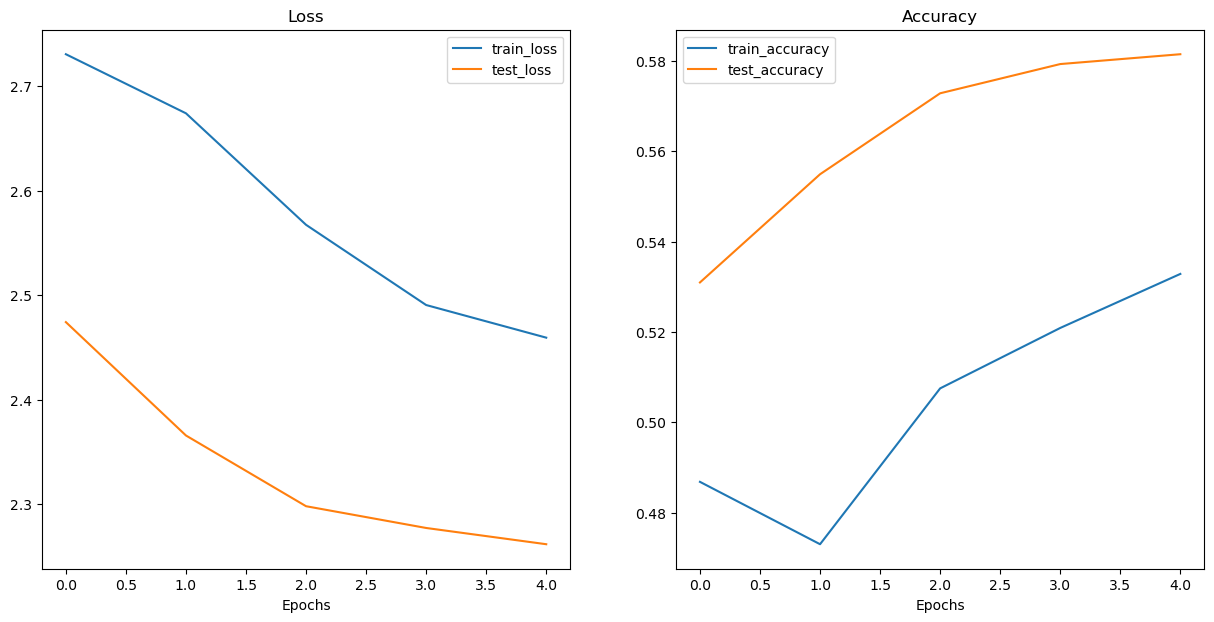

In [90]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

### 10.7 Saving and loading FoodVision Big

In [92]:
from going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth" 

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [93]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

### 10.8 Checking FoodVision Big model size

In [94]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


## 11. Turning our FoodVision Big model into a deployable app

In [95]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

### 11.1 Downloading an example image and moving it to the examples directory

In [96]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg 
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2025-06-29 12:13:13--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
raw.githubusercontent.com (raw.githubusercontent.com) をDNSに問いあわせています... 2606:50c0:8002::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 2874848 (2.7M) [image/jpeg]
`04-pizza-dad.jpeg' に保存中

04-pizza-dad.jpeg   100%[===================>]   2.74M  7.90MB/s 時間 0.3s       

2025-06-29 12:13:14 (7.90 MB/s) - `04-pizza-dad.jpeg' へ保存完了 [2874848/2874848]



### 11.2 Saving Food101 class names to file (class_names.txt)

In [98]:
# Check out the first 10 Food101 class names
food101_class_name[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [100]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_name)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [101]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]
    
# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 11.3 Turning our FoodVision Big model into a Python script (model.py)

In [102]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning our FoodVision Big Gradio app into a Python script (app.py)

In [103]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]
    
### 2. Model and transforms preparation ###    

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface 
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/foodvision_big/app.py


### 11.5 Creating a requirements file for FoodVision Big (requirements.txt)

In [104]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.7.0
torchvision==0.22.0
gradio==5.35.0

Overwriting demos/foodvision_mini/requirements.txt


### 11.6 Zip foodvision_big folder

In [105]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"


  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 54%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 56%)
